### 尝试边界

In [2]:
%pylab inline
from abmdiffuse import Diffuse
from bassestimate import BassEstimate
from pymongo import MongoClient
import numpy as np
import pylab as pl
import networkx as nx
import datetime
import time

Populating the interactive namespace from numpy and matplotlib


In [3]:
client = MongoClient('localhost', 27017)
db = client.abmDiffusion
prj = db.networks

In [4]:
class Gen_para:
    def __init__(self, g, p_cont=(0.001, 0.02), q_cont=(0.08, 0.1), delta=(0.0005, 0.01)):
        self.p_cont = p_cont
        self.q_cont = q_cont
        self.d_p, self.d_q = delta
        self.g = g

    def add_data(self, p, q):
        diff = Diffuse(p, q, g=self.g)
        x = np.mean(diff.repete_diffuse(), axis=0)
        max_idx = np.argmax(x)
        s = x[:(max_idx + 2)]
        para_range = [[1e-6, 0.1], [1e-5, 0.8], [s, 4*self.g.number_of_nodes()]]
        bassest = BassEstimate(s, para_range)
        bassest.t_n = 1000
        res = bassest.optima_search(c_n=200, threshold=10e-6)
        return res[1:3]  # P, Q

    def identify_range(self):
        min_p, max_p = self.p_cont
        min_q, max_q = self.q_cont
        est_cont = [self.add_data(p, q) for p, q in [(min_p, min_q), (max_p, max_q)]]
        i = 1
        while True:  # P: 0.007~0.03, Q: 0.38~0.53
            min_P, min_Q = est_cont[0]
            max_P, max_Q = est_cont[1]
            print(i, f'P:{min_P:.4f}~{max_P:.4f}', f'Q:{min_Q:.4f}~{max_Q:.4f}' )
            c1, c2 = 0, 0
            # 如果min_P大于下限，则减少min_p的下限值；另防止min_p < 0
            if min_P > 0.0007:
                min_p = min_p - self.d_p if min_p > self.d_p else 0.0003
                c1 += 1

            if min_Q > 0.38:  # 如果min_Q小于下限，则减少min_q的下限值
                min_q -= self.d_q
                c1 += 1

            if max_P < 0.03:  # 如果max_P小于上限，则增加max_p的上限值
                max_p += self.d_p
                c2 += 1

            if max_Q < 0.53:  # 如果max_Q小于上限，则增加max_q的上限值
                max_q += self.d_q
                c2 += 1

            i += 1

            if c1 + c2 != 0:  # 查看是否进行了更新
                if c1 != 0:  # 如果min_p或者min_q更新了，则减少
                    est_cont[0] = self.add_data(min_p, min_q)
                if c2 != 0:  # 如果max_p或者max_q更新了，则增加
                    est_cont[1] = self.add_data(max_p, max_q)
            else:
                break

            if i == 20:
                break

        return {"p_range": [min_p, max_p], "q_range": [min_q, max_q],
                "P_range": [min_P, max_P], "Q_range": [min_Q, max_Q]}

    def generate_sample(self, n_p=10, n_q=20):
        rg_p, rg_q = self.identify_range()
        sp_cont = [(p, q) for p in np.linspace(rg_p[0], rg_p[1], n_p) 
                        for q in np.linspace(rg_q[0], rg_q[1], n_q)]
        return sp_cont

In [5]:
def generate_random_graph(degre_sequance):
    G = nx.configuration_model(degre_sequance, create_using=None, seed=None)
    G = nx.Graph(G)
    G.remove_edges_from(G.selfloop_edges())
    return G

def func(p, q, g):
    diff = Diffuse(p, q, g=g, num_runs=40)
    x = np.mean(diff.repete_diffuse(), axis=0)
    return np.concatenate(([p, q], x))

In [6]:
expon_seq = np.load('dataSources/exponential_sequance.npy')
gauss_seq = np.load('dataSources/gaussian_sequance.npy')
logno_seq = np.load('dataSources/lognormal_sequance.npy')
facebook_graph = nx.read_gpickle('dataSources/facebook.gpickle')
epinions_graph = nx.read_gpickle('dataSources/epinions.gpickle')   
g_cont = [nx.barabasi_albert_graph(10000, 3), generate_random_graph(expon_seq), 
          generate_random_graph(gauss_seq), nx.gnm_random_graph(10000, 100000), 
          nx.gnm_random_graph(10000, 30000), nx.gnm_random_graph(10000, 40000), 
          nx.gnm_random_graph(10000, 50000), nx.gnm_random_graph(10000, 60000),
          nx.gnm_random_graph(10000, 70000), nx.gnm_random_graph(10000, 80000), 
          nx.gnm_random_graph(10000, 90000), generate_random_graph(logno_seq),
          nx.watts_strogatz_graph(10000, 6, 0), nx.watts_strogatz_graph(10000, 6, 0.1),
          nx.watts_strogatz_graph(10000, 6, 0.3), nx.watts_strogatz_graph(10000, 6, 0.5),
          nx.watts_strogatz_graph(10000, 6, 0.7), nx.watts_strogatz_graph(10000, 6, 0.9),
          nx.watts_strogatz_graph(10000, 6, 1),
          facebook_graph, epinions_graph]

txt_cont = ['barabasi_albert_graph(10000,3)', 'exponential_graph(10000,3)', 
            'gaussian_graph(10000,3)', 'gnm_random_graph(10000,100000)', 
            'gnm_random_graph(10000,30000)', 'gnm_random_graph(10000,40000)', 
            'gnm_random_graph(10000,50000)', 'gnm_random_graph(10000,60000)',
            'gnm_random_graph(10000,70000)', 'gnm_random_graph(10000,80000)', 
            'gnm_random_graph(10000,90000)', 'lognormal_graph(10000,3)',
            'watts_strogatz_graph(10000,6,0)', 'watts_strogatz_graph(10000,6,0.1)',
            'watts_strogatz_graph(10000,6,0.3)', 'watts_strogatz_graph(10000,6,0.5)',
            'watts_strogatz_graph(10000,6,0.7)', 'watts_strogatz_graph(10000,6,0.9)',
            'watts_strogatz_graph(10000,6,1.0)',
            'facebook_graph', 'epinions_graph']

#### 确定初始边界

(1) barabasi_albert_graph(10000,3), `p_cont = [0.0001, 0.001], q_cont = [0.03, 0.08]`

(2) exponential_graph(10000,3), 

(3) gaussian_graph(10000,3),

(4) gnm_random_graph

(5) lognormal_graph(1000,3)

(6) watts_strogatz_graph

#### epinions网络分析

In [89]:
from collections import Counter

In [7]:
epinions_graph.number_of_nodes(), epinions_graph.number_of_edges()

(75879, 508837)

In [46]:
in_cont = epinions_graph.in_degree()
out_cont = epinions_graph.out_degree()
c = 0
for key in dict(in_cont):
    if in_cont[key] == 0 and out_cont[key] == 0:
        c += 1

In [49]:
inDegree = list(dict(in_cont).values())
outDegree = list(dict(out_cont).values())

In [93]:
in_count = Counter(inDegree)

In [ ]:
in_count.

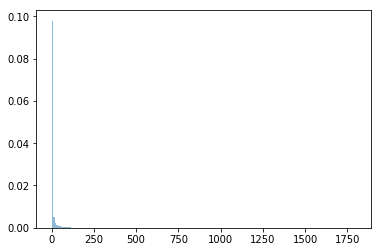

In [58]:
n, bins, patches = pl.hist(outDegree, 200, alpha=0.5, density=1)

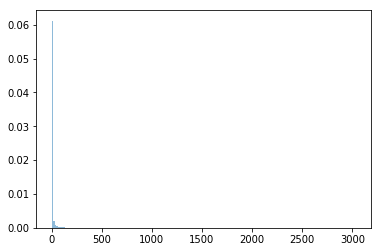

In [59]:
n, bins, patches = pl.hist(inDegree, 200, alpha=0.5, density=1)

In [37]:
u = list(b.values())
u.count(0)

15538

In [60]:
nx.degree_assortativity_coefficient(epinions_graph)

-0.04128630053133649

In [26]:
nx.average_clustering(g_cont[3])

0.0019651694267569164

In [8]:
facebook_graph.number_of_nodes(), facebook_graph.number_of_edges()

(4039, 88234)

In [65]:
i = -1
t1 = time.perf_counter()
g = g_cont[-1]
p, q = 0.001, 0.005
diff = Diffuse(p, q, g, num_runs=200)
diff_cont = diff.repete_diffuse()
S = np.mean(diff_cont, axis=0)
print(f"Time elasped:{time.perf_counter()-t1:.2f}s")
print(f"网络:{txt_cont[i]}")
print(f"最大采纳量{np.max(S)}, 最大时间步:{np.argmax(S)}")

Time elasped:396.36s
网络:epinions_graph
最大采纳量410.5, 最大时间步:18


In [ ]:
import plotly as py
from plotly.graph_objs import Histogram, Scatter, Layout, Data, XAxis, Figure
import plotly.figure_factory as ff
py.offline.init_notebook_mode()

In [ ]:
x1, x2 = dataset

trace0 = Scatter(
    x = x1,
    name='',
    cumulative={"enabled":False},
    opacity = 0.75,
    xaxis="x1")

trace1 = Histogram(
    x=x2,
    name='',
    histnorm='probability',
    cumulative={"enabled":False},
    opacity=0.75,
    xaxis="x2")

data = [trace0, trace1]
layout = Layout(barmode='overlay', 
                title='众筹开始至成功的时间跨度',
                xaxis1={"domain": [0, 0.5], 
                        "title": "绝对跨度"}, 
                xaxis2={"domain": [0.5, 1], 
                        "title": "相对跨度"}
               )

fig = Figure(data=data, layout=layout)
py.offline.iplot(fig, filename='sixth_chart.html')

In [102]:
round(p, 5), round(q, 5)

(0.00639, 0.18876)

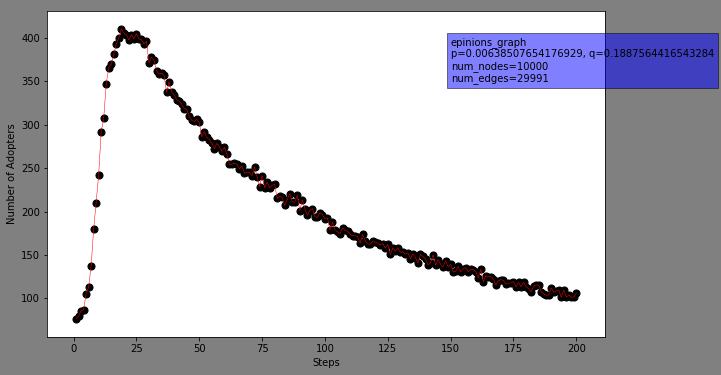

In [100]:
fig = pl.figure(figsize=(10, 6), facecolor='grey')
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("Steps")
ax.set_ylabel("Number of Adopters")
ax.plot(np.arange(1, len(S)+1), S, 'r-', lw=0.5)
ax.scatter(np.arange(1, len(S)+1), S, s=50, marker='o', c='k')
text = ax.text(150, 350, f"{txt_cont[i]}\np={p}, q={q}\nnum_nodes={nx.number_of_nodes(g)}\nnum_edges={nx.number_of_edges(g)}", 
                bbox=dict(facecolor='blue', alpha=0.5))

In [88]:
m_idx = np.argmax(S)
s = S[:m_idx + 2]
t1 = time.process_time()
para_range = [[1e-5, 0.1], [1e-5, 0.8], [sum(s), 10*sum(s)]]
bassest = BassEstimate(s, para_range)
mse, p, q, m = bassest.optima_search(c_n=100, threshold=10e-6)
r_2 = bassest.r2([p, q, m])
print(f'Time elapsed: {(time.process_time() - t1):.2f}s')
print(f'P:{p:.4f}   Q:{q:.4f}   M:{m:.0f}\nr^2:{r_2:.4f}')

Time elapsed: 0.66s
P:0.0064   Q:0.1888   M:8126
r^2:0.9898


In [95]:
t1 = time.perf_counter()
print(txt_cont[i])
p_cont = (0.0004, 0.022)
q_cont = (0.07, 0.1)
delta = (0.0005, 0.003)
ger_samp = Gen_para(g=g, p_cont=p_cont, q_cont=q_cont, delta=delta)
bound = ger_samp.identify_range()
print(f'time: {time.perf_counter() - t1:.2f}s')

gaussian_graph(10000,3)
1 P:0.0006~0.0260 Q:0.4126~0.6235
Exceed the maximal iteration: 100
2 P:0.0007~0.0274 Q:0.3784~0.6301
Exceed the maximal iteration: 100
3 P:0.0004~0.0271 Q:0.3845~0.6201
Exceed the maximal iteration: 100
4 P:0.0005~0.0279 Q:0.3708~0.6240
5 P:0.0005~0.0296 Q:0.3708~0.5975
6 P:0.0005~0.0301 Q:0.3708~0.6142
time: 98.83s


In [96]:
bound

{'p_range': [0.0003, 0.0245],
 'q_range': [0.064, 0.1],
 'P_range': [0.0005222022707075201, 0.030091799531446122],
 'Q_range': [0.37081158400930625, 0.6141919385783103]}

In [97]:
prj.insert_one({'_id':txt_cont[i], 'param_boundary':{"ctime": datetime.datetime.now(), **bound}})

### watts_strogatz_graph

In [85]:
for i in range(13, 19):
    t1 = time.perf_counter()
    print(txt_cont[i])
    g = g_cont[i]
    p_cont = (0.0005, 0.024)  
    q_cont = (0.06, 0.1)  # 小心设置
    delta = (0.0002, 0.005)
    ger_samp = Gen_para(g=g, p_cont=p_cont, q_cont=q_cont, delta=delta)
    bound = ger_samp.identify_range()
    prj.update_one({'_id':txt_cont[i]}, {'$set':{'param_boundary':{"ctime": datetime.datetime.now(), **bound}}})
    print(f'time: {time.perf_counter() - t1:.2f}s')

watts_strogatz_graph(10000,6,0.1)
1 P:0.0012~0.0321 Q:0.1493~0.4328
2 P:0.0008~0.0334 Q:0.1441~0.4450
3 P:0.0007~0.0315 Q:0.1285~0.4634
4 P:0.0007~0.0335 Q:0.1285~0.4908
5 P:0.0007~0.0337 Q:0.1285~0.5351
time: 91.92s
watts_strogatz_graph(10000,6,0.3)
1 P:0.0009~0.0289 Q:0.2225~0.4887
Exceed the maximal iteration: 100
2 P:0.0005~0.0298 Q:0.2269~0.5030
3 P:0.0005~0.0305 Q:0.2269~0.5083
4 P:0.0005~0.0300 Q:0.2269~0.5353
time: 64.06s
watts_strogatz_graph(10000,6,0.5)
Exceed the maximal iteration: 100
1 P:0.0007~0.0291 Q:0.2560~0.5014
Exceed the maximal iteration: 100
2 P:0.0004~0.0285 Q:0.2553~0.5235
3 P:0.0004~0.0284 Q:0.2553~0.5454
4 P:0.0004~0.0289 Q:0.2553~0.5483
5 P:0.0004~0.0292 Q:0.2553~0.5578
6 P:0.0004~0.0297 Q:0.2553~0.5508
7 P:0.0004~0.0292 Q:0.2553~0.5718
8 P:0.0004~0.0296 Q:0.2553~0.5478
9 P:0.0004~0.0309 Q:0.2553~0.5620
time: 85.04s
watts_strogatz_graph(10000,6,0.7)
1 P:0.0007~0.0273 Q:0.2736~0.5176
2 P:0.0007~0.0283 Q:0.2736~0.5266
3 P:0.0007~0.0278 Q:0.2736~0.5621
4 P:0.000

In [ ]:
for x in prj.find({}, {projection={"param_boundary.p_range":1, "param_boundary.q_range":1, "param_boundary.ctime":1}}):
    print(x['_id'], x['p_range'], x['q_range'])

In [79]:
prj.find_one({"_id": 'gnm_random_graph(10000,30000)'})

{'_id': 'gnm_random_graph(10000,30000)',
 'param_boundary': {'ctime': datetime.datetime(2018, 12, 15, 15, 48, 27, 673000),
  'p_range': [0.0003, 0.025890000000000024],
  'q_range': [0.056999999999999995, 0.10200000000000001],
  'P_range': [0.00040099198571325625, 0.028546612735487212],
  'Q_range': [0.2901573180113419, 0.5643354306957634]}}

In [104]:
list(prj.find({},projection={"_id":1}))

[{'_id': 'barabasi_albert_graph(10000,3)'},
 {'_id': 'exponential_graph(10000,3)'},
 {'_id': 'gnm_random_graph(10000,30000)'},
 {'_id': 'gnm_random_graph(10000,40000)'},
 {'_id': 'gnm_random_graph(10000,50000)'},
 {'_id': 'gnm_random_graph(10000,60000)'},
 {'_id': 'gnm_random_graph(10000,70000)'},
 {'_id': 'gnm_random_graph(10000,80000)'},
 {'_id': 'gnm_random_graph(10000,90000)'},
 {'_id': 'gnm_random_graph(10000,100000)'},
 {'_id': 'lognormal_graph(10000,3)'},
 {'_id': 'watts_strogatz_graph(10000,6,0)'},
 {'_id': 'watts_strogatz_graph(10000,6,0.1)'},
 {'_id': 'watts_strogatz_graph(10000,6,0.3)'},
 {'_id': 'watts_strogatz_graph(10000,6,0.5)'},
 {'_id': 'watts_strogatz_graph(10000,6,0.7)'},
 {'_id': 'watts_strogatz_graph(10000,6,0.9)'},
 {'_id': 'watts_strogatz_graph(10000,6,1.0)'},
 {'_id': 'gaussian_graph(10000,3)'}]

In [94]:
g = eval('nx.' + 'barabasi_albert_graph(10000,3)')

In [99]:
txt_cont = [x['_id'] for x in prj.find({}, projection={'_id':1})]

['barabasi_albert_graph(10000,3)',
 'exponential_graph(10000,3)',
 'gnm_random_graph(10000,30000)',
 'gnm_random_graph(10000,40000)',
 'gnm_random_graph(10000,50000)',
 'gnm_random_graph(10000,60000)',
 'gnm_random_graph(10000,70000)',
 'gnm_random_graph(10000,80000)',
 'gnm_random_graph(10000,90000)',
 'gnm_random_graph(10000,100000)',
 'lognormal_graph(10000,3)',
 'watts_strogatz_graph(10000,6,0)',
 'watts_strogatz_graph(10000,6,0.1)',
 'watts_strogatz_graph(10000,6,0.3)',
 'watts_strogatz_graph(10000,6,0.5)',
 'watts_strogatz_graph(10000,6,0.7)',
 'watts_strogatz_graph(10000,6,0.9)',
 'watts_strogatz_graph(10000,6,1.0)',
 'gaussian_graph(10000,3)']